In [357]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess
import holidays

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")

In [358]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_weekday", "post_month", "post_day", "post_year", "release_post", 
         "days_since_previous_release"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "day", "month"]])
df = df[df["release_post"] == True].copy()

In [359]:
df.head()

,post_weekday,post_month,day,year,release_post,days_since_previous_release,month,date
id,,,,,,,,
183,Friday,February,17,2017,True,0.0,2,2017-02-17
197,Sunday,February,26,2017,True,9.0,2,2017-02-26
109,Saturday,March,18,2017,True,20.0,3,2017-03-18
57,Friday,March,24,2017,True,6.0,3,2017-03-24
196,Thursday,March,30,2017,True,6.0,3,2017-03-30


In [360]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})

In [361]:
df = pandas.get_dummies(df, columns=["post_weekday"], prefix="WD")

In [362]:
df = df.groupby(["month", "year"]).agg(
    {c : ("mean" if c == "days_since_previous_release" else "sum") for c in df.columns 
     if c.startswith("WD_") or c == "release_post" or c == "days_since_previous_release"}).reset_index().rename(
    columns={"release_post" : "number_of_releases", "days_since_previous_release" : "avg_days_between_releases"})
df["day"] = 1
df["date"] = pandas.to_datetime(df[["year", "day", "month"]])
df = df.set_index("date")
df.index = df.index.to_period("M")

In [363]:
df["holidays"] = df.apply(
    lambda x : len([h for h in nj_holidays if h.month == x["month"] and h.year == x["year"]]), axis=1)

In [364]:
del df["month"]
del df["day"]
del df["year"]
df = df.sort_index()
df.head()

,number_of_releases,avg_days_between_releases,WD_Friday,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,WD_Wednesday,holidays
date,,,,,,,,,,
2017-02,2,4.500000,1,0,0,1,0,0,0,4
2017-03,3,10.666667,1,0,1,0,1,0,0,1
2017-04,4,5.250000,1,0,2,1,0,0,0,1
2017-05,3,9.333333,2,0,0,1,0,0,0,1
2017-06,5,7.000000,3,0,2,0,0,0,0,0


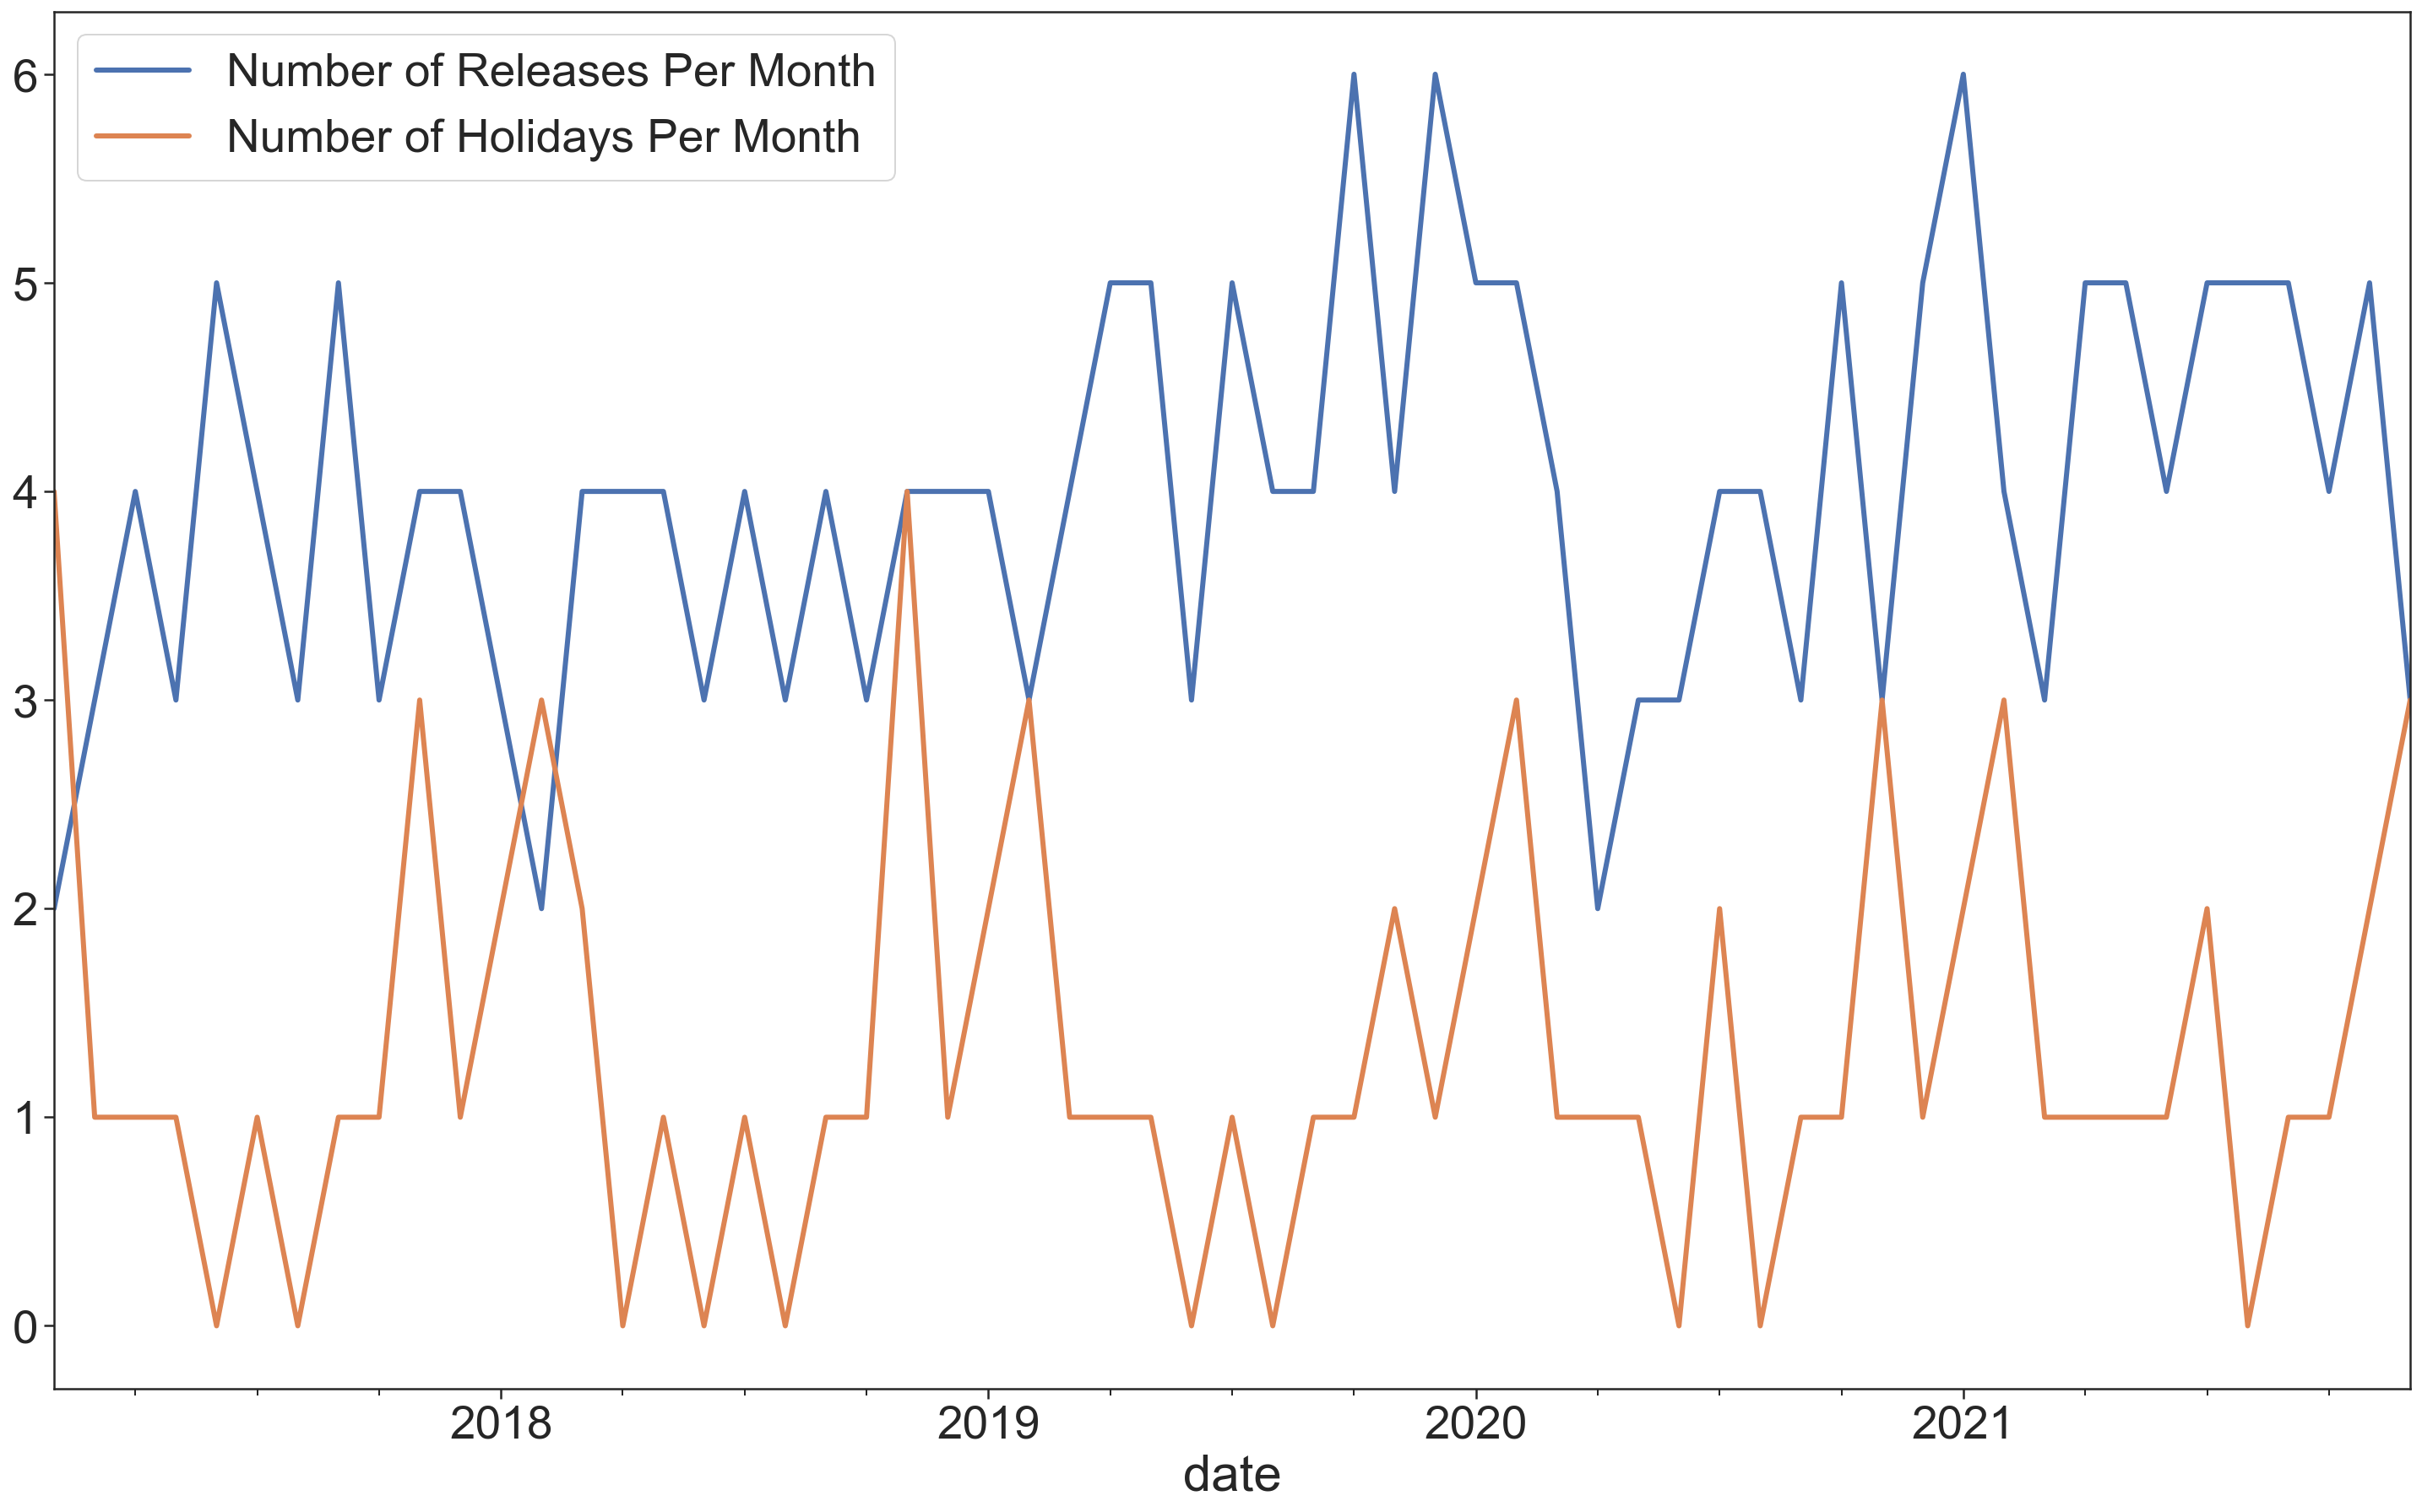

In [365]:
ax = df["number_of_releases"].plot(linewidth=3)
df["holidays"].plot(ax=ax, linewidth=3)
# df["avg_days_between_releases"].plot(ax=ax, linewidth=3)
ax.legend(["Number of Releases Per Month", "Number of Holidays Per Month"])
plt.show()

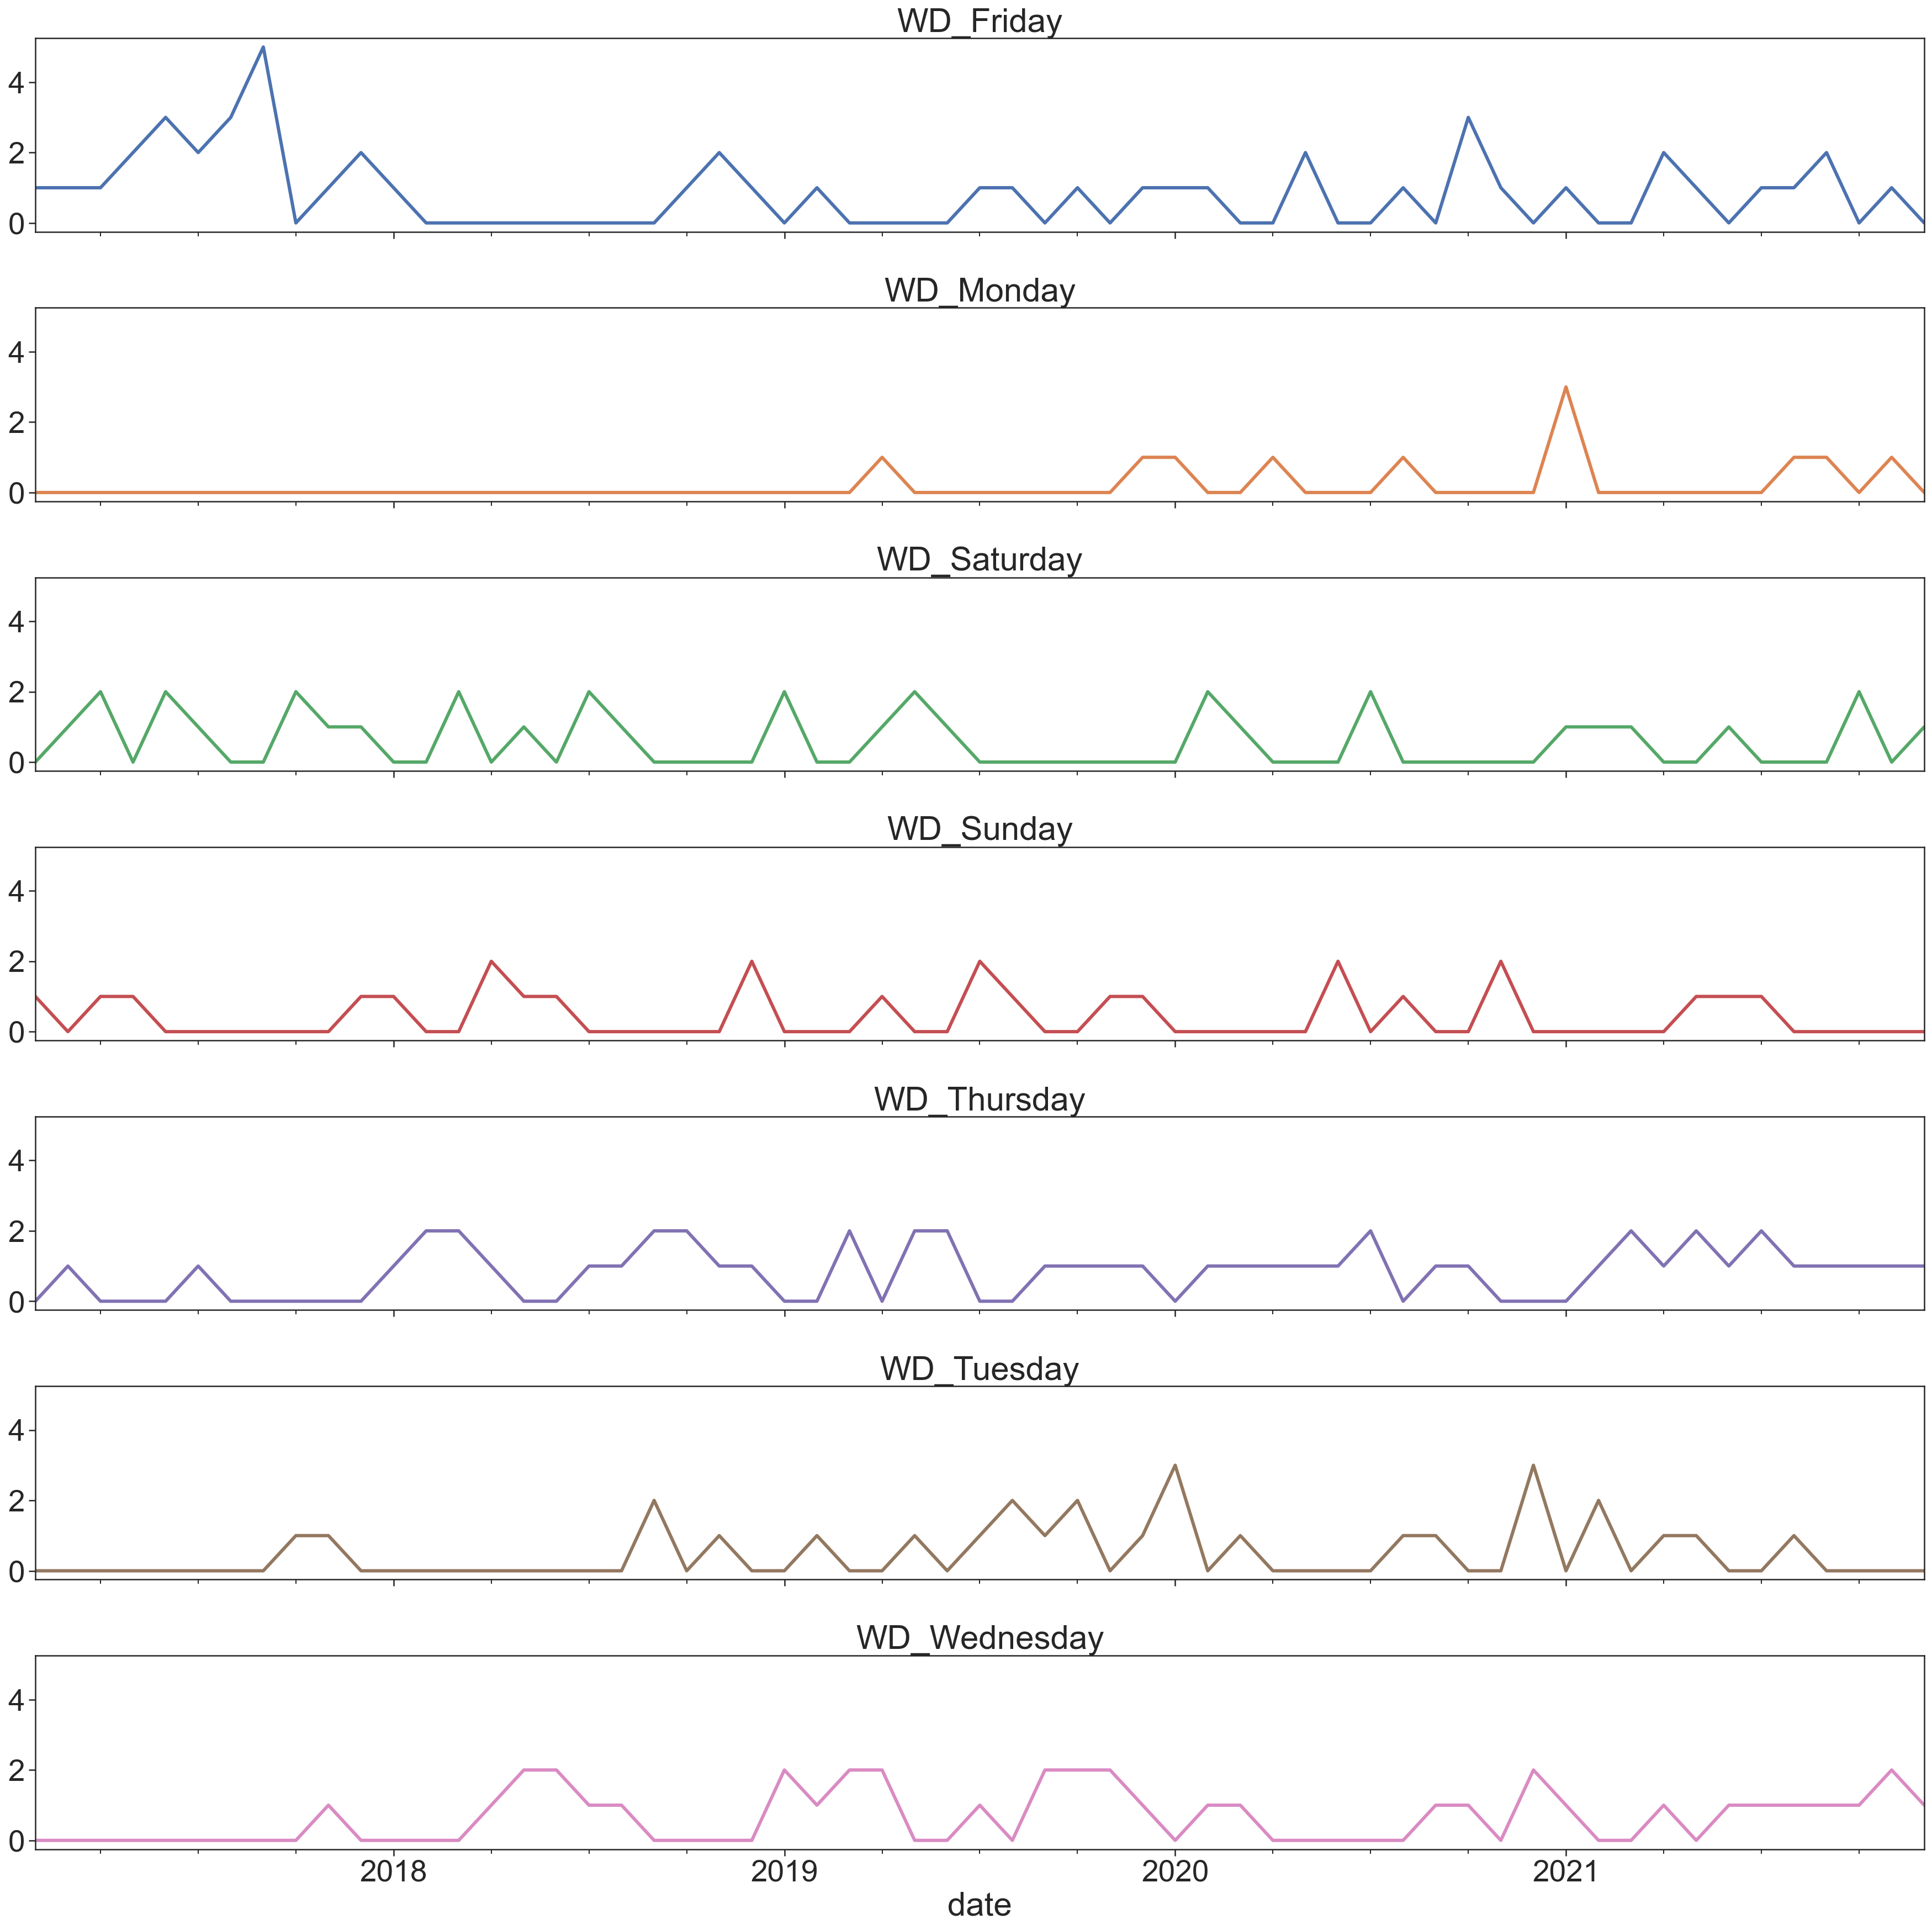

In [366]:
(fig, axs) = plt.subplots(7, sharex=True, sharey=True)
fig.set_size_inches(25, 25)
palette = sns.color_palette(None, 7)
for (i, col) in enumerate([c for c in df.columns if c.startswith("WD_")]):
    df[col].plot(ax=axs[i], linewidth=3, title=col, color=palette[i])
plt.tight_layout()

In [367]:
# temp = df.rolling(window=4, center=True, win_type="cosine").mean()
# temp["number_of_releases"].plot(linewidth=3)

In [368]:
# df["releases_lag_1"] = df["number_of_releases"].shift(1)

In [369]:
# df["month"] = df.index.month
# df = pandas.get_dummies(df, columns=["month"], prefix="month")

In [370]:
# dp = DeterministicProcess(df.index, order=2, seasonal=False, fourier=1, drop=True)
# df = df.join(dp.in_sample())

In [371]:
df[[c for c in df.columns if not c.startswith("WD_")]].corr()[["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
avg_days_between_releases,-0.525587
holidays,-0.117366


In [372]:
df[[c for c in df.columns if c.startswith("WD_") or c == "number_of_releases"]].corr()[["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
WD_Friday,0.257552
WD_Monday,0.390184
WD_Saturday,0.059232
WD_Sunday,-0.043029
WD_Thursday,-0.053148
WD_Tuesday,0.331324
WD_Wednesday,0.366441


In [373]:
len(df) * 0.85

50.15

In [374]:
train_df = df[0:50].copy()
len(train_df)

50

In [375]:
test_df = df[50:-1].copy() # the last one is the current month
len(test_df)

8

In [376]:
features = [c for c in train_df.columns if 
            c != "number_of_releases" and 
            "lag" not in c and 
            not c.startswith("WD_") and
            not c.startswith("month_") and
            c != "predicted"]
features

['avg_days_between_releases', 'holidays']

In [377]:
cv = RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=1024, criterion="absolute_error"),
                        cv=3, random_state=1024, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                        refit=True,
                        param_distributions={
                            "min_samples_split" : list(range(2, 12, 2)),
                            "min_samples_leaf" : list(range(1, 11)),
                            "min_weight_fraction_leaf" : [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5],
                            "max_features" : [None, "auto", "sqrt", "log2"],
                            "max_leaf_nodes" : [None, 2, 3, 4, 5],
                            "min_impurity_decrease" : [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
                            "ccp_alpha" : [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]})
cv.fit(train_df[features], train_df["number_of_releases"])
cv.best_score_

-0.1650531045751634

In [378]:
cv.best_params_

{'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': 3,
 'max_features': 'auto',
 'ccp_alpha': 0}

In [379]:
list(zip(features, cv.best_estimator_.feature_importances_))

[('avg_days_between_releases', 1.0), ('holidays', 0.0)]

In [380]:
test_df["predicted"] = cv.predict(test_df[features])

In [381]:
test_df[["number_of_releases", "predicted"]]

,number_of_releases,predicted
date,,
2021-04,5,4.0
2021-05,5,4.0
2021-06,4,4.0
2021-07,5,4.0
2021-08,5,4.0
2021-09,5,4.0
2021-10,4,4.0
2021-11,5,4.0


In [382]:
mape(test_df["number_of_releases"], test_df["predicted"])

0.15000000000000002

In [383]:
(df.iloc[-1]["number_of_releases"], cv.predict(df[-1:][features]))

(3.0, array([4.]))

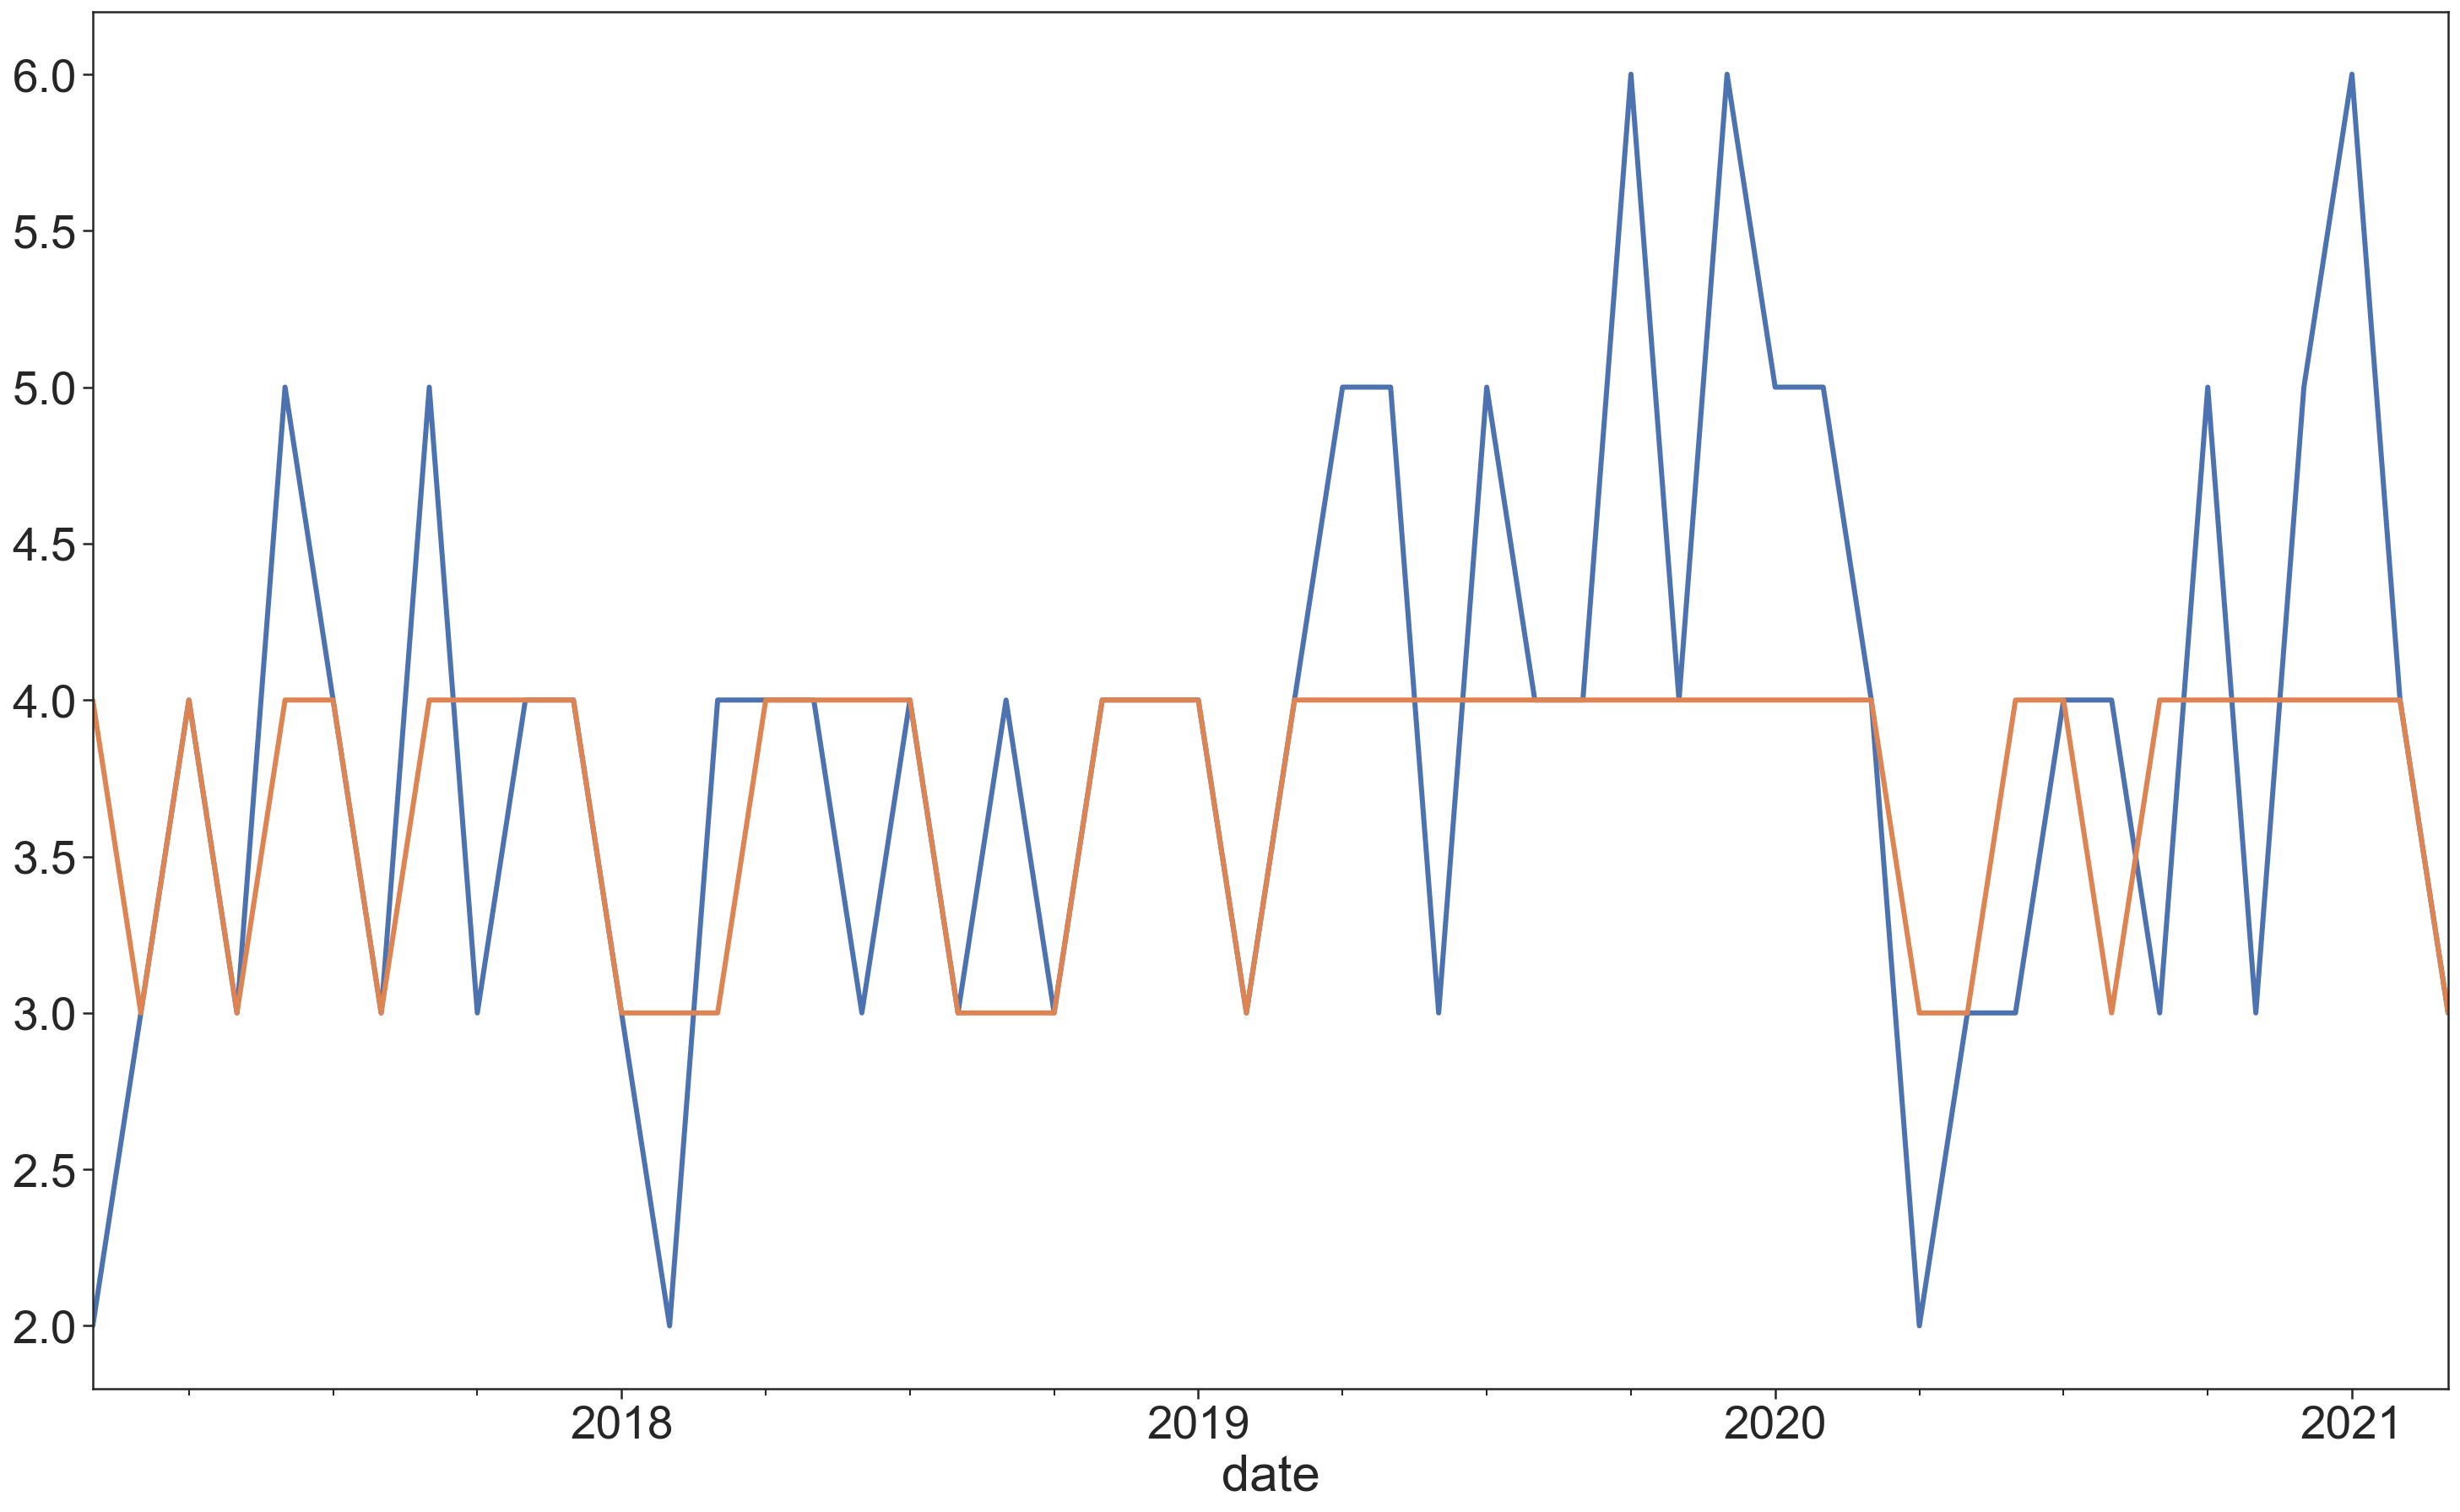

In [384]:
train_df["predicted"] = cv.predict(train_df[features])
ax = train_df["number_of_releases"].plot(linewidth=3)
train_df["predicted"].plot(linewidth=3, ax=ax)
plt.show()